In [33]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from nltk.sentiment.vader import SentimentIntensityAnalyzer

url = "https://finance.yahoo.com/topic/stock-market-news/"
response = requests.get(url)
print(response)

<Response [200]>


In [5]:
def get_page(url):
    response = requests.get(url)
    if not response.ok:
        print('Status code:', response.status_code)
        raise Exception('Failed to load page {}'.format(url))
    html_content = response.content
    soup = BeautifulSoup(html_content, "html.parser")
    return soup

In [29]:
#show title of webpage
html_content = response.content
soup = BeautifulSoup(html_content, "html.parser")
soup.find('title')

<title>Latest Stock Market News</title>

In [30]:
#finding tags or headlines in stock news articles 
div_tags = soup.find_all('div', {'class': "Ov(h) Pend(44px) Pstart(25px)"})

In [31]:
len(div_tags)

10

In [32]:
#printing the source and the headline of the article 
print("Source: ", div_tags[1].find('div').text)
print("Head Line : {}".format(div_tags[1].find('a').text))

Source:  Bloomberg
Head Line : S&P Has Peaked for 2024, Bank of America Forecasts


In [33]:
print("Source: ", div_tags[2].find('div').text)
print("Head Line : {}".format(div_tags[2].find('a').text))

Source:  Motley Fool
Head Line : 3 Reasons to Buy Amazon Stock Before August 1


In [34]:
print("Source: ", div_tags[0].find('div').text)
print("Head Line : {}".format(div_tags[0].find('a').text))

Source:  Bloomberg
Head Line : Stocks Rise Before Fed With Earnings in Full Swing: Markets Wrap


In [35]:
for headline in div_tags:
    #print(headline.get_text())
    print("Head Line : {}".format(headline.find('a').text))

Head Line : Stocks Rise Before Fed With Earnings in Full Swing: Markets Wrap
Head Line : S&P Has Peaked for 2024, Bank of America Forecasts
Head Line : 3 Reasons to Buy Amazon Stock Before August 1
Head Line : PayPal Lifts Outlook and Stock Buybacks on Transactions
Head Line : Stock market news today: S&P 500, Nasdaq drop in wait for key earnings, Fed meeting kicks off
Head Line : 1 Top Artificial Intelligence (AI) Stock Billionaires Are Selling Right Now
Head Line : S&P Global Boosts Outlook as Rating Unit Thrives Amid Debt Surge
Head Line : U.S. job openings fall slightly to 8.2 million as high interest rates slowly cool a hot labor market
Head Line : Great Stock Rotation Hinges on Powell Signaling Rate Cuts Soon
Head Line : Drop in Magnificent Seven could drag down U.S. stocks, top fund manager says


In [36]:
def get_news_tags(soup):
    #Get the list of tags containing news information
    news_class = "Ov(h) Pend(44px) Pstart(25px)" 
    news_list  = soup.find_all('div', {'class': news_class})
    return news_list

In [37]:
BASE_URL = 'https://finance.yahoo.com' #Global Variable 

def parse_news(news_tag):
    #Get the news data point and return dictionary
    news_source = news_tag.find('div').text #source
    news_headline = news_tag.find('a').text #heading
    news_url = news_tag.find('a')['href'] #link
    news_content = news_tag.find('p').text #content
    news_image = news_tag.findParent().find('img')['src'] #thumb image
    return { 'source' : news_source,
            'headline' : news_headline,
            'url' : BASE_URL + news_url,
            'content' : news_content,
            'image' : news_image
           }

In [38]:
def scrape_yahoo_news(url, path=None):
    #Get the yahoo finance market news and write them to CSV file
    if path is None:
        path = 'stock-market-news.csv'
        
    print('Requesting html page')
    doc = get_page(url)

    print('Extracting news tags')
    news_list = get_news_tags(soup)

    print('Parsing news tags')
    news_data = [parse_news(news_tag) for news_tag in news_list]

    print('Save the data to a CSV')
    news_df = pd.DataFrame(news_data)
    news_df.to_csv(path, index=None)
    
    return news_df 

In [39]:
#output of saving csv file function
YAHOO_NEWS_URL = url
news_df = scrape_yahoo_news(YAHOO_NEWS_URL)

Requesting html page
Extracting news tags
Parsing news tags
Save the data to a CSV


In [40]:
# NLTK VADER for sentiment analysis
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# New words and values
new_words = {
    'gain': 100,
    'crushes': 10,
    'beats': 5,
    'misses': -5,
    'trouble': -10,
    'falls': -100,
    'crash': -100
}
# Instantiate the sentiment intensity analyzer with the existing lexicon
vader = SentimentIntensityAnalyzer()
# Update the lexicon
vader.lexicon.update(new_words)

print('ok!')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/josephmorrow/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


ok!


In [41]:
# Use these column names
columns = ['headline']
# Convert the list of lists into a DataFrame
scored_news = pd.DataFrame(news_df, columns=columns)

# Iterate through the headlines and get the polarity scores
scores = scored_news['headline'].apply(vader.polarity_scores)

# Convert the list of dicts into a DataFrame
scores_df = pd.DataFrame.from_records(scores)

# Join the DataFrames
scored_news = scored_news.join(scores_df)

# Convert the date column from string to datetime
#scored_news['date'] = pd.to_datetime(scored_news.date).dt.date
print(scored_news)

                                            headline    neg    neu    pos  \
0  Stocks Rise Before Fed With Earnings in Full S...  0.000  1.000  0.000   
1  S&P Has Peaked for 2024, Bank of America Forec...  0.000  1.000  0.000   
2      3 Reasons to Buy Amazon Stock Before August 1  0.000  0.779  0.221   
3  PayPal Lifts Outlook and Stock Buybacks on Tra...  0.000  1.000  0.000   
4  Stock market news today: S&P 500, Nasdaq drop ...  0.116  0.884  0.000   
5  1 Top Artificial Intelligence (AI) Stock Billi...  0.000  0.620  0.380   
6  S&P Global Boosts Outlook as Rating Unit Thriv...  0.181  0.652  0.167   
7  U.S. job openings fall slightly to 8.2 million...  0.000  0.739  0.261   
8  Great Stock Rotation Hinges on Powell Signalin...  0.154  0.559  0.287   
9  Drop in Magnificent Seven could drag down U.S....  0.214  0.481  0.305   

   compound  
0    0.0000  
1    0.0000  
2    0.1779  
3    0.0000  
4   -0.2732  
5    0.5994  
6   -0.0516  
7    0.6486  
8    0.4404  
9    0.4019 

In [53]:
print(scored_news.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   headline  10 non-null     object 
 1   neg       10 non-null     float64
 2   neu       10 non-null     float64
 3   pos       10 non-null     float64
 4   compound  10 non-null     float64
dtypes: float64(4), object(1)
memory usage: 532.0+ bytes
None


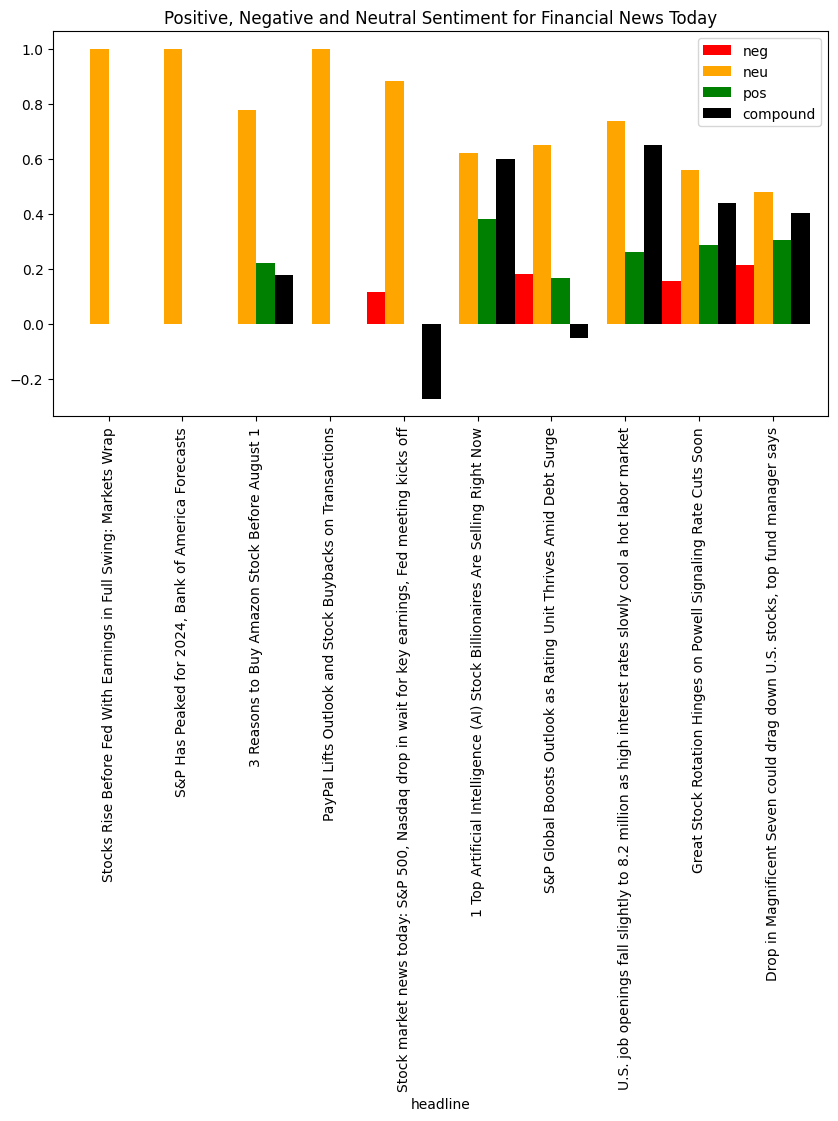

In [64]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

COLORS = ["red", "orange", "green", "black"]
plot_scores = scored_news.drop(['compound'], axis=1)
plot_scores.columns = ['negative', 'positive', 'neutral', 'compound']

scored_news.plot(x='headline', kind='bar',
        title='Positive, Negative and Neutral Sentiment for Financial News Today', color=COLORS, figsize=(10,5), width=1)
plt.show()